In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [4]:
# Load dataset
df = pd.read_csv('Mall_Customers.csv')

# Select numerical features for clustering
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Find optimal K for K-Means (Elbow Method)
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

In [6]:
# Find optimal number of components for GMM using BIC
bic_scores = []
for n in range(2, 10):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

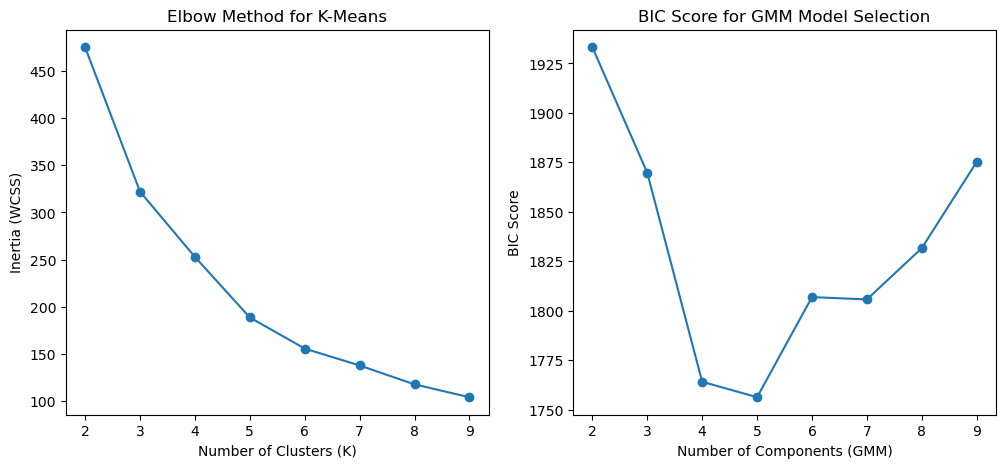

In [7]:
# Plot Elbow Method & BIC in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method Plot
axes[0].plot(K_range, inertia, marker='o')
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Inertia (WCSS)")
axes[0].set_title("Elbow Method for K-Means")

# BIC Score Plot for GMM
axes[1].plot(range(2, 10), bic_scores, marker='o')
axes[1].set_xlabel("Number of Components (GMM)")
axes[1].set_ylabel("BIC Score")
axes[1].set_title("BIC Score for GMM Model Selection")

plt.show()

In [14]:
# Apply K-Means with chosen K
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply GMM with chosen number of components
gmm = GaussianMixture(n_components=4, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(X_scaled)

In [15]:
# Function to draw circles around K-Means clusters
def draw_kmeans_circles(ax, kmeans, X_scaled, kmeans_labels):
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_points = X_scaled[kmeans_labels == i]
        std_dev = np.std(cluster_points, axis=0)
        circle = patches.Circle(center, std_dev[0] * 2, color='red', fill=False, 
                                linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(circle)

# Function to draw ellipses for GMM clusters
def draw_gmm_ellipses(ax, gmm, X_scaled):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        covariances = gmm.covariances_[i]

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)

        # Extract the angle of rotation
        largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        angle = np.degrees(np.arctan2(largest_eigenvector[1], largest_eigenvector[0]))

        # Width and height of the ellipse (95% confidence interval)
        width = 2 * np.sqrt(eigenvalues[0])
        height = 2 * np.sqrt(eigenvalues[1])

        # Create and add the ellipse
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor='blue',
                                  facecolor='none', linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(ellipse)

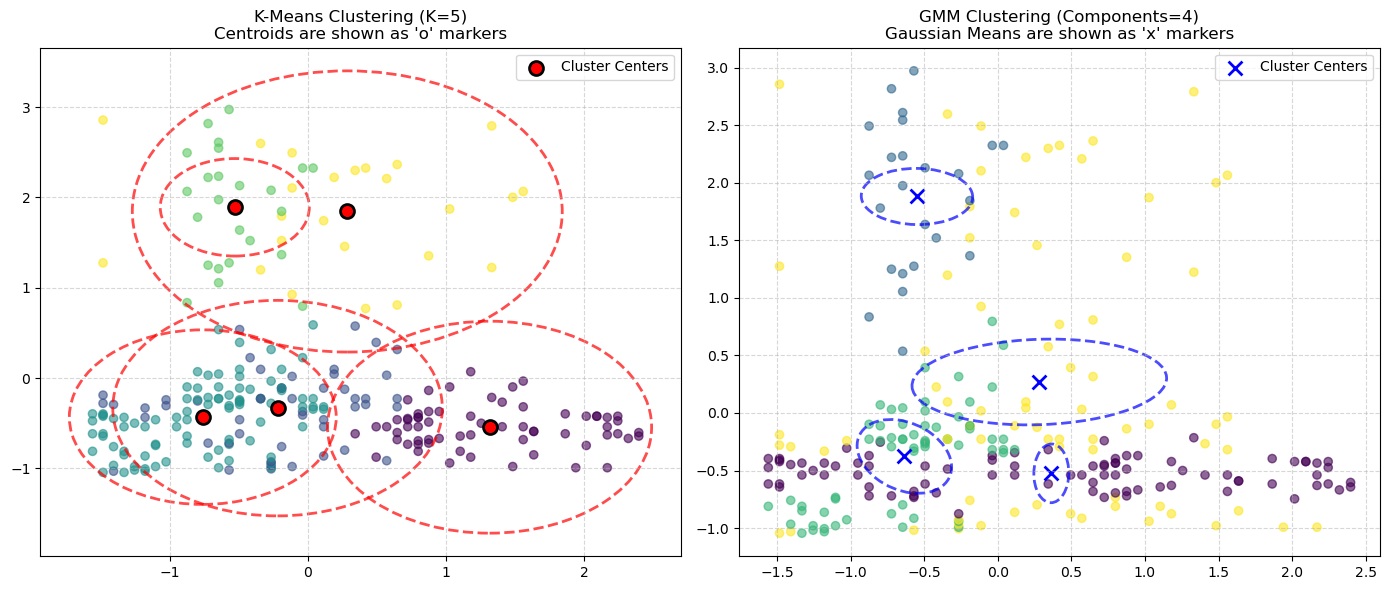

In [16]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust size for clarity

# K-Means Plot
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=100, c='red', marker='o', edgecolors='black', linewidth=2, label="Cluster Centers")
draw_kmeans_circles(axes[0], kmeans, X_scaled, kmeans_labels)
axes[0].set_title("K-Means Clustering (K=5)\nCentroids are shown as 'o' markers")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# GMM Plot
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_labels, cmap='viridis', alpha=0.6)
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                s=100, c='blue', marker='x', linewidth=2, label="Cluster Centers")
draw_gmm_ellipses(axes[1], gmm, X_scaled)
axes[1].set_title("GMM Clustering (Components=4)\nGaussian Means are shown as 'x' markers")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plots
plt.show()